In [1060]:
import pandas as pd
import matplotlib.axes as ax
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

## Executive Summary

Military coups have existed since as far as 800 BC. They occur when an illegitimate claimant to power seizes power within a state for at least seven days. Although coups have been fewer in recent time, there have been about 460 coups attempts since 1950 (of which roughly 50% were successful). In past century, coups have been mostly common in Africa and the Americas, with fewer coups occurring Europe. Most of the coup attempts in the past 60 years occurred in the 1960s, at the same times majority of African nations gained independece from the Europeans. However, in recent times, successful coups have been less frequent either because governments have developed new methods in containing the usurpers, or because recent coup leaders are less strategic in claiming the throne. That, however, is a data science question for another project. 

Although successful coups are more prominent, attempted coups are more frequent than one would expect. In the past 16 years along, there have been 30 attempted coups (seven successful), with majority occurring in Africa. Many of these coup attemps did not gain as much international attention as that of Turkey that occurred July 15, 2016. The recent coups attempts causes one to wonder if there ways to predict a coup attempt (successful or not), given the social and polical climate in a state.

Problem Statement: Considerig social and political instabilities that have occured in recent times, I want predict the likelihood of a coup d'etat within a country, given specific economic, political and social factors.

- Economic factors: income per capita, growth rate
- Social factors: accounts of ethnic violence, reglious, linguistic, and ethnic fractionalization, fatalities from 
  violence, urbanisation
- Political factors: polity score, length of stay for incumbent head of state
  

In [946]:
coup = pd.read_csv("../assets/csv/Coups.csv")
stab = pd.read_csv("../assets/csv/Politicalinstability2.csv")
polity = pd.read_csv("../assets/csv/polity.csv")
leaders = pd.read_csv("../assets/csv/leaders.csv")
urban = pd.read_csv("../assets/csv/urbanpop.csv")
gdp = pd.read_csv("../assets/csv/Realpercapitagdp.csv")
growth = pd.read_csv("../assets/csv/GDPgrowth.csv")

In [947]:
coup.head()

,country,year,scoup1,atcoup2
0,Afghanistan,1955,0,0
1,Afghanistan,1956,0,0
2,Afghanistan,1957,0,0
3,Afghanistan,1958,0,0
4,Afghanistan,1959,0,0


In [948]:
coup.shape

(8748, 4)

In [949]:
# Summing scoup1(successful coups) and acoup1(attempted coups) to generate sumcoup
# I want a columns with binary variables that indicates coup (successful and attempted) or no coup
coup["sumcoup"] = coup["scoup1"] + coup["atcoup2"]

# To make a bianry column
coupbin = []
for i in coup["sumcoup"].tolist():
    if i > 0:
        coupbin.append(1)
    if i == 0:
        coupbin.append(0)
coup["Coup"] = coupbin

In [950]:
# Dropping unnecessary columns
coup.drop(["scoup1", "atcoup2", "sumcoup"], axis=1, inplace=True)

In [951]:
stab.head()

,COUNTRY,YEAR,PTYPE,GENDEATHMAG,ETHMAGFATAL,ETHMAGFIGHT,REVMAGFATAL,REVMAGFIGHT
0,Afghanistan,1955,0,0.0,0,0,0,0
1,Afghanistan,1956,0,0.0,0,0,0,0
2,Afghanistan,1957,0,0.0,0,0,0,0
3,Afghanistan,1958,0,0.0,0,0,0,0
4,Afghanistan,1959,0,0.0,0,0,0,0


In [952]:
stab.shape

(5162, 8)

In [953]:
# To covert the variables in PTYPE to dummy variables 
dummies = pd.get_dummies(stab["PTYPE"])
stab = stab[["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
             "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT"]].join(dummies)

stab.columns = ["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
                "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT", "NONE",
                "ETH", "REV", "GEN"]

In [954]:
# To avoid repetition of rows, I want to group the dataframes bq
aggMap = { "NONE" : "sum", "ETH" : "sum", "REV" : "sum", 
           "GEN" : "sum", "GENDEATHMAG" : "sum", 
           "ETHMAGFATAL" : "sum", "ETHMAGFIGHT" : "sum", 
           "REVMAGFATAL" : "sum", "REVMAGFIGHT" : "sum" }

stabGrouped = stab.groupby(["COUNTRY","YEAR"]).agg(aggMap).reset_index()

In [955]:
stabGrouped.head()

,COUNTRY,YEAR,NONE,REVMAGFIGHT,GENDEATHMAG,ETHMAGFATAL,REVMAGFATAL,ETH,ETHMAGFIGHT,REV,GEN
0,Afghanistan,1955,1.0,0,0.0,0,0,0.0,0,0.0,0.0
1,Afghanistan,1956,1.0,0,0.0,0,0,0.0,0,0.0,0.0
2,Afghanistan,1957,1.0,0,0.0,0,0,0.0,0,0.0,0.0
3,Afghanistan,1958,1.0,0,0.0,0,0,0.0,0,0.0,0.0
4,Afghanistan,1959,1.0,0,0.0,0,0,0.0,0,0.0,0.0


In [956]:
# Joining the political stabilty and coup tables 
coup1 = coup.merge(stabGrouped, how="inner", left_on=["country", "year"], right_on=["COUNTRY", "YEAR"])

In [957]:
# dropping the unnecessary columns and setting all columns to lower case for easier manipulation in the future
coup1.drop(["COUNTRY", "YEAR"], axis=1, inplace=True)
coup1.columns = map(str.lower, coup1.columns)

In [958]:
coup1.head()

,country,year,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen
0,Afghanistan,1955,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0
1,Afghanistan,1956,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0
2,Afghanistan,1957,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0
3,Afghanistan,1958,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0
4,Afghanistan,1959,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0


In [959]:
polity.head()

,country,year,flag,fragment,democ,autoc,polity,polity2,durable
0,Afghanistan,1940,0,NaN,0,8,-8,-8,NaN
1,Afghanistan,1941,0,NaN,0,8,-8,-8,NaN
2,Afghanistan,1942,0,NaN,0,8,-8,-8,NaN
3,Afghanistan,1943,0,NaN,0,8,-8,-8,NaN
4,Afghanistan,1944,0,NaN,0,8,-8,-8,NaN


In [960]:
# Dropping unnecessary variables
polity.drop(["flag", "fragment", "democ", "autoc", "polity"], axis=1, inplace=True)

In [961]:
# Merging polity table with coup1 table
coup2 = coup1.merge(polity, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [962]:
coup2.head()

,country,year,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable
0,Afghanistan,1955,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN
1,Afghanistan,1956,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN
2,Afghanistan,1957,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN
3,Afghanistan,1958,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN
4,Afghanistan,1959,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN


In [963]:
leaders.head()

,country,year,yip
0,Afghanistan,1946,13
1,Afghanistan,1947,14
2,Afghanistan,1948,15
3,Afghanistan,1949,16
4,Afghanistan,1950,17


In [964]:
# Merging coup2 and leaders
coup3 = coup2.merge(leaders, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [965]:
coup3.head()

,country,year,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip
0,Afghanistan,1955,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN,22
1,Afghanistan,1956,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN,23
2,Afghanistan,1957,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN,24
3,Afghanistan,1958,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN,25
4,Afghanistan,1959,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-10,NaN,26


In [966]:
urban.head()

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,8.22,8.51,8.81,9.11,9.43,9.75,10.09,10.43,10.79,...,23.24,23.59,23.95,24.31,24.69,25.07,25.47,25.87,26.28,26.70
1,Albania,30.71,30.94,31.02,31.09,31.16,31.23,31.30,31.37,31.45,...,47.82,48.90,49.99,51.08,52.16,53.25,54.33,55.38,56.41,57.41
2,Algeria,30.51,31.80,33.21,34.66,36.14,37.64,38.84,39.00,39.17,...,64.59,65.35,66.10,66.82,67.53,68.21,68.87,69.51,70.13,70.73
3,American Samoa,66.21,66.64,67.07,67.49,67.92,68.33,68.75,69.16,69.57,...,88.00,87.90,87.80,87.70,87.59,87.50,87.41,87.33,87.26,87.20
4,Andorra,58.45,60.98,63.46,65.87,68.21,70.45,72.59,74.64,76.59,...,89.84,89.36,88.87,88.35,87.82,87.26,86.71,86.17,85.63,85.12


In [967]:
# I want to change the shape of the table, so the year columns become rows
Col1 = urban.columns[0]
Col2 = urban.columns[1:].tolist()
urban1 = pd.melt(urban, id_vars=(Col1), var_name="year", value_vars=(Col2), value_name="urbanpop")
urban1.sort_values(["country", "year"], inplace=True)

In [968]:
urban1.head()

,country,year,urbanpop
0,Afghanistan,1960,8.22
216,Afghanistan,1961,8.51
432,Afghanistan,1962,8.81
648,Afghanistan,1963,9.11
864,Afghanistan,1964,9.43


In [969]:
gdp.head()

,country,1969,1970,1971,1972,1973,1974,1975,1976,1977,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,$283,$287,$291,$294,$297,$300,$302,$304,$305,...,$380,$428,$438,$516,$547,$568,$636,$634,$632,$624
1,Albania,"$1,873","$1,881","$1,893","$1,905","$1,936","$1,951","$1,967","$1,984","$2,001",...,"$3,251","$3,459","$3,729","$3,856","$3,993","$4,084","$4,139","$4,186","$4,253","$4,541"
2,Algeria,"$2,671","$2,823","$2,433","$3,011","$3,036","$3,168","$3,228","$3,394","$3,465",...,"$4,345","$4,416","$4,424","$4,412","$4,484","$4,521","$4,581","$4,620","$4,720","$4,794"
3,Angola,"$3,185","$3,172","$3,141","$3,112","$3,089","$3,154","$3,251","$3,260","$3,182",...,"$3,671","$4,371","$4,836","$4,814","$4,839","$4,885","$4,991","$5,184","$5,239","$4,153"
4,Antigua and Barbuda,"$3,321","$3,413","$3,530","$3,656","$3,794","$3,950","$4,119","$4,288","$4,467",...,"$15,408","$16,652","$16,448","$14,281","$13,089","$12,689","$13,031","$12,857","$13,106","$13,681"


The gdp table shows the real per capita GDP of each country from 1969 to 2015.

In [970]:
# Also changing the shape of the table here
Col3 = gdp.columns[0]
Col4 = gdp.columns[1:].tolist()
gdp1 = pd.melt(gdp, id_vars=(Col3), var_name="year", value_vars=(Col4), value_name="gdppercap")
gdp1.sort_values(["country", "year"], inplace=True)

In [971]:
gdp1.head()

,country,year,gdppercap
0,Afghanistan,1969,$283
190,Afghanistan,1970,$287
380,Afghanistan,1971,$291
570,Afghanistan,1972,$294
760,Afghanistan,1973,$297


In [972]:
# Cleaning the values in the gdp1 table
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace('$', '')
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace(',', '')

In [973]:
# Coverting the values to numeric
gdp1['gdppercap'] = gdp1['gdppercap'].convert_objects(convert_numeric=True)
gdp1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdppercap    float64
dtype: object

In [974]:
growth.head()

,country,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,..,..,..,..,..,..,..,..,..,...,5.55,13.74,3.61,21.02,8.43,6.11,14.43,1.96,1.31,1.52
1,Albania,..,..,..,..,..,..,..,..,..,...,5.43,5.9,7.53,3.35,3.71,2.55,1.42,1.11,2,2.56
2,Algeria,-13.61,-19.69,34.31,5.84,6.21,-4.8,9.45,10.8,8.43,...,1.7,3.4,2.4,1.6,3.6,2.9,3.4,2.8,3.8,3.9
3,American Samoa,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,...,4.59,0.08,-8.59,-3.82,-5.35,-4.8,-1.76,-0.06,..,..


In [975]:
# Changing the shape of the table
Col5 = growth.columns[0]
Col6 = growth.columns[1:].tolist()
growth1 = pd.melt(growth, id_vars=(Col5), var_name="year", value_vars=(Col6), value_name="gdpgrowth")
growth1.sort_values(["country", "year"], inplace=True)

In [976]:
growth1.head()

,country,year,gdpgrowth
0,Afghanistan,1961,..
217,Afghanistan,1962,..
434,Afghanistan,1963,..
651,Afghanistan,1964,..
868,Afghanistan,1965,..


In [977]:
# Converting to numeric
growth1['gdpgrowth'] = growth1['gdpgrowth'].convert_objects(convert_numeric=True)
growth1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdpgrowth    float64
dtype: object

In [978]:
# Joining tables again
Econ = gdp1.merge(growth1, how="inner", left_on=["country", "year"], right_on=["country", "year"])
Econ1 = Econ.merge(urban1, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [979]:
Econ1.head()

,country,year,gdppercap,gdpgrowth,urbanpop
0,Afghanistan,1969,283.0,NaN,11.15
1,Afghanistan,1970,287.0,4.04,11.53
2,Afghanistan,1971,291.0,3.88,11.92
3,Afghanistan,1972,294.0,3.74,12.32
4,Afghanistan,1973,297.0,3.60,12.73


In [980]:
#Econ1.dtypes

In [981]:
# Convert the year column to numeric
Econ1["year"] = Econ1["year"].convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [982]:
# Final join!
DF = Econ1.merge(coup3, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [983]:
DF.head()

,country,year,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip
0,Afghanistan,1969,283.0,NaN,11.15,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,5.0,36
1,Afghanistan,1970,287.0,4.04,11.53,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,6.0,37
2,Afghanistan,1971,291.0,3.88,11.92,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,7.0,38
3,Afghanistan,1972,294.0,3.74,12.32,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,8.0,39
4,Afghanistan,1973,297.0,3.60,12.73,1,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,9.0,40


In [984]:
# Incorporating a new table into the dataframe
# Importing the csv file as a list of lists
# Converting the list to a data dictionary, with the countries being the keys and ethinic, linguistic, and religious
# fractionalization respectively serving as the values

path = "../assets/csv/diversity.csv"
import csv

def read_file(path):
    with open(path, 'r') as f:
        diversity = [row for row in csv.reader(f.read().splitlines())]
    return diversity

diversity = read_file(path)
diversity = diversity[1:]
#print diversity

def function(i):return (i[0], i[1:])
div_dict = map(function, diversity)
divDict = dict(div_dict)
#print myNewDict


In [985]:
# Matching the values from the dictionary to their respective countries

loc = DF["country"].tolist()


ethnicity = []
linguistic = []
religious = []


for i in loc:
    for country, ethnic in myNewDict.items():
        if i == country:
            ethnicity.append( ethnic[0] )
            linguistic.append( ethnic[1] )
            religious.append( ethnic[2] )

In [986]:
#Assigning these values to their respective columns
DF["ethnic"] = ethnicity
DF["linguistic"] = linguistic
DF["religious"] = religious

In [987]:
DF.head()

,country,year,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,...,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
0,Afghanistan,1969,283.0,NaN,11.15,0,1.0,0,0.0,0,...,0.0,0,0.0,0.0,-7,5.0,36,0.7693,0.6141,0.2717
1,Afghanistan,1970,287.0,4.04,11.53,0,1.0,0,0.0,0,...,0.0,0,0.0,0.0,-7,6.0,37,0.7693,0.6141,0.2717
2,Afghanistan,1971,291.0,3.88,11.92,0,1.0,0,0.0,0,...,0.0,0,0.0,0.0,-7,7.0,38,0.7693,0.6141,0.2717
3,Afghanistan,1972,294.0,3.74,12.32,0,1.0,0,0.0,0,...,0.0,0,0.0,0.0,-7,8.0,39,0.7693,0.6141,0.2717
4,Afghanistan,1973,297.0,3.60,12.73,1,1.0,0,0.0,0,...,0.0,0,0.0,0.0,-7,9.0,40,0.7693,0.6141,0.2717


In [988]:
DF.count()

country        3121
year           3121
gdppercap      3068
gdpgrowth      3068
urbanpop       3121
coup           3121
none           3121
revmagfight    3121
gendeathmag    3121
ethmagfatal    3121
revmagfatal    3121
eth            3121
ethmagfight    3121
rev            3121
gen            3121
polity2        3121
durable        3121
yip            3121
ethnic         3121
linguistic     3121
religious      3121
dtype: int64

In [989]:
# Drop rows with missing values (since they are relatively few)
# Drop the year columns since I won't be needing it for my analysis
DF.dropna(axis=0, how="any", inplace=True)
DF.drop(["year"], axis=1, inplace=True)

In [990]:
DF["coup"].value_counts()

0    2861
1     185
Name: coup, dtype: int64

In [991]:
# Converting year column to numeric
DF[["ethnic", "linguistic", "religious"]] = DF[["ethnic", "linguistic", "religious"]] \
                                            .convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [992]:
#DF.dtypes

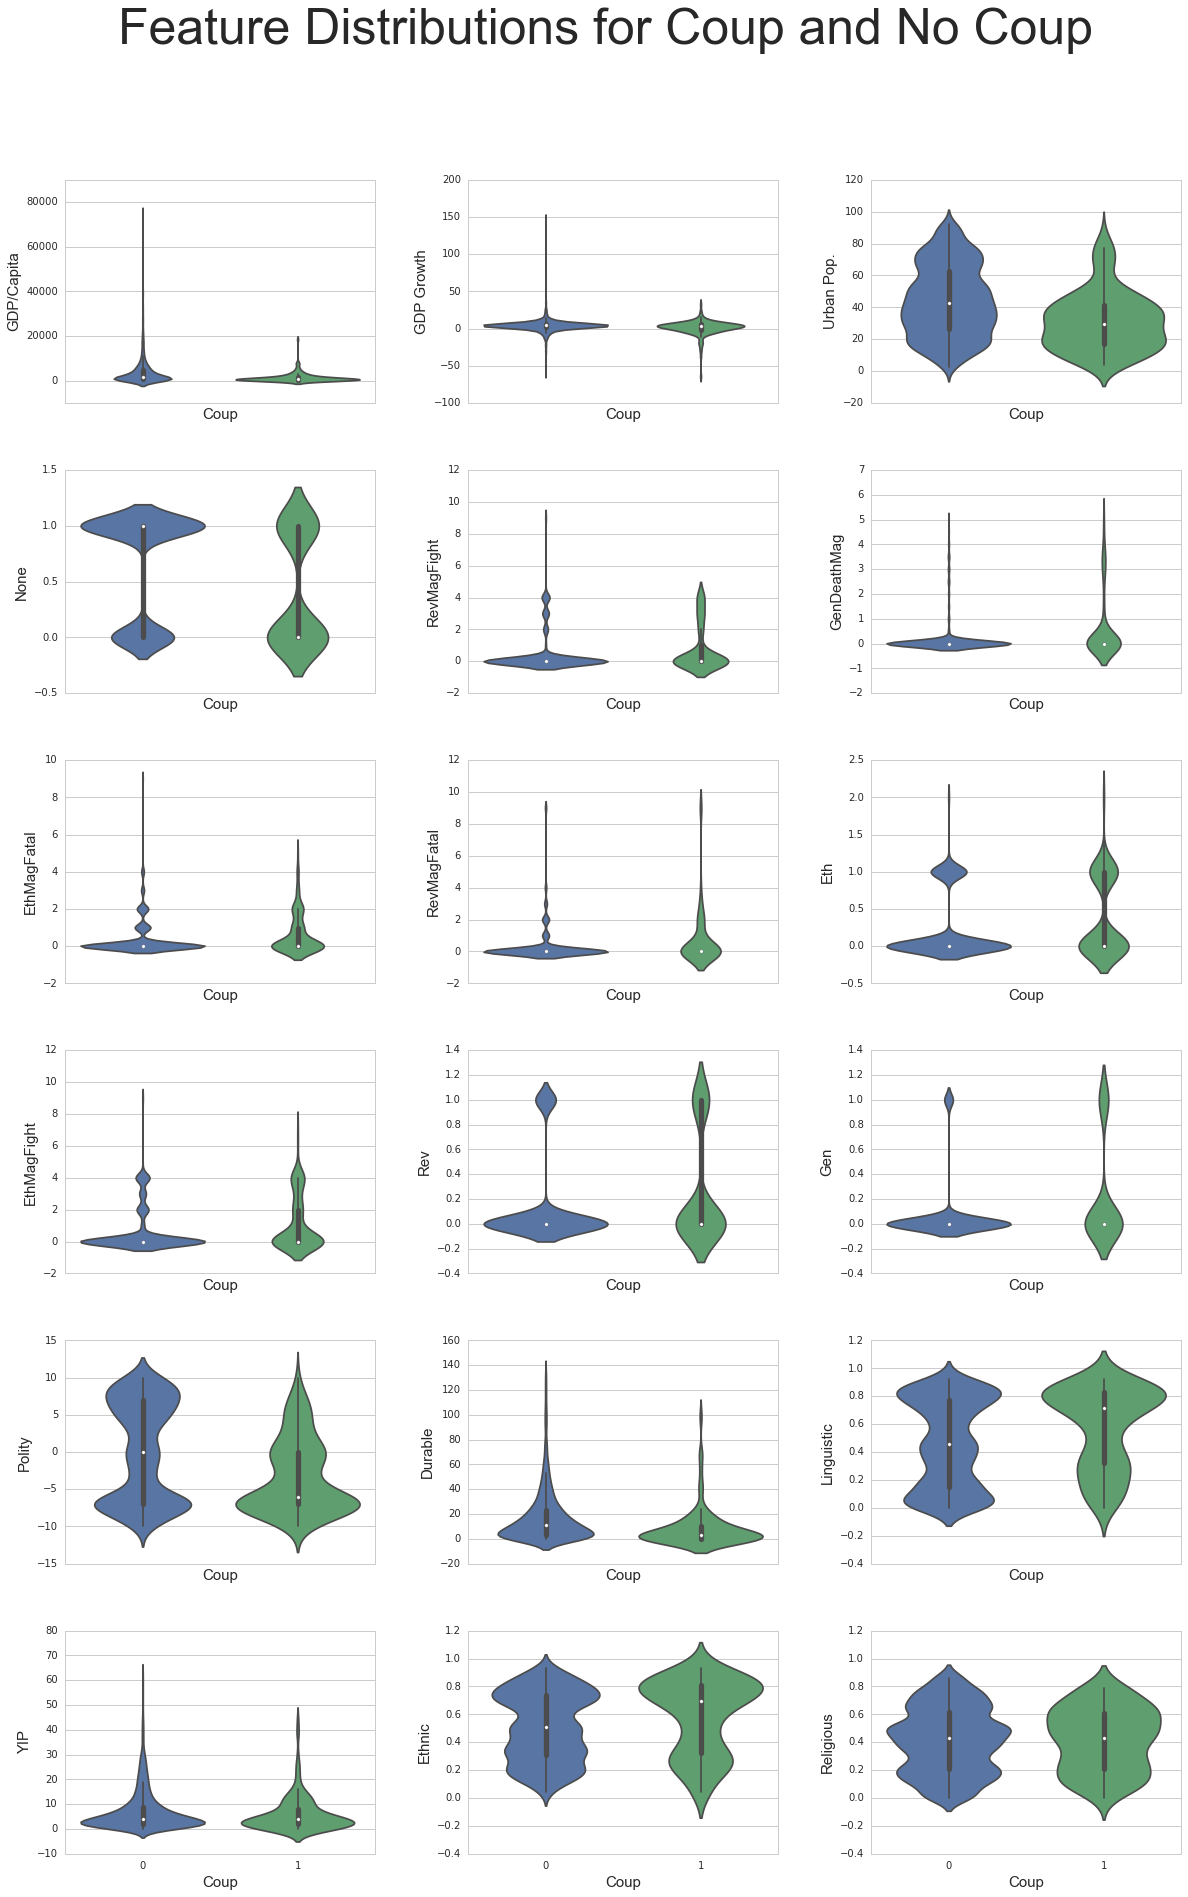

In [1059]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), \
      (ax13, ax14, ax15), (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, \
        sharey=False, sharex=True, figsize=(20,30))
fig.suptitle("Feature Distributions for Coup and No Coup", size=50)

sns.set_style("whitegrid")
sns.violinplot(x='coup', y="gdppercap", data=DF, ax=ax1)
ax1.set_xlabel("Coup", fontsize=15)
ax1.set_ylabel("GDP/Capita", fontsize=15)  
    
sns.violinplot(x='coup', y="gdpgrowth", data=DF, ax=ax2)
ax2.set_xlabel("Coup", fontsize=15)
ax2.set_ylabel("GDP Growth", fontsize=15)

sns.violinplot(x='coup', y="urbanpop", data=DF, ax=ax3)
ax3.set_xlabel("Coup", fontsize=15)
ax3.set_ylabel("Urban Pop.", fontsize=15)

sns.violinplot(x='coup', y="none", data=DF, ax=ax4)
ax4.set_xlabel("Coup", fontsize=15)
ax4.set_ylabel("None", fontsize=15)

sns.violinplot(x='coup', y="revmagfight", data=DF, ax=ax5)
ax5.set_xlabel("Coup", fontsize=15)
ax5.set_ylabel("RevMagFight", fontsize=15)

sns.violinplot(x='coup', y="gendeathmag", data=DF, ax=ax6)
ax6.set_xlabel("Coup", fontsize=15)
ax6.set_ylabel("GenDeathMag", fontsize=15)

sns.violinplot(x='coup', y="ethmagfatal", data=DF, ax=ax7)
ax7.set_xlabel("Coup", fontsize=15)
ax7.set_ylabel("EthMagFatal", fontsize=15)

sns.violinplot(x='coup', y="revmagfatal", data=DF, ax=ax8)
ax8.set_xlabel("Coup", fontsize=15)
ax8.set_ylabel("RevMagFatal", fontsize=15)

sns.violinplot(x='coup', y="eth", data=DF, ax=ax9)
ax9.set_xlabel("Coup", fontsize=15)
ax9.set_ylabel("Eth", fontsize=15)

sns.violinplot(x='coup', y="ethmagfight", data=DF, ax=ax10)
ax10.set_xlabel("Coup", fontsize=15)
ax10.set_ylabel("EthMagFight", fontsize=15)

sns.violinplot(x='coup', y="rev", data=DF, ax=ax11)
ax11.set_xlabel("Coup", fontsize=15)
ax11.set_ylabel("Rev", fontsize=15)

sns.violinplot(x='coup', y="gen", data=DF, ax=ax12)
ax12.set_xlabel("Coup", fontsize=15)
ax12.set_ylabel("Gen", fontsize=15)

sns.violinplot(x='coup', y="polity2", data=DF, ax=ax13)
ax13.set_xlabel("Coup", fontsize=15)
ax13.set_ylabel("Polity", fontsize=15)

sns.violinplot(x='coup', y="durable", data=DF, ax=ax14)
ax14.set_xlabel("Coup", fontsize=15)
ax14.set_ylabel("Durable", fontsize=15)

sns.violinplot(x='coup', y="linguistic", data=DF, ax=ax15)
ax15.set_xlabel("Coup", fontsize=15)
ax15.set_ylabel("Linguistic", fontsize=15)

sns.violinplot(x='coup', y="yip", data=DF, ax=ax16)
ax16.set_xlabel("Coup", fontsize=15)
ax16.set_ylabel("YIP", fontsize=15)

sns.violinplot(x='coup', y="ethnic", data=DF, ax=ax17)
ax17.set_xlabel("Coup", fontsize=15)
ax17.set_ylabel("Ethnic", fontsize=15)

sns.violinplot(x='coup', y="religious", data=DF, ax=ax18)
ax18.set_xlabel("Coup", fontsize=15)
ax18.set_ylabel("Religious", fontsize=15)

fig.subplots_adjust(hspace=.3, wspace=.3)

In [993]:
# To split the dataframe into one with instances of a coup and another with instances of no coup
acoup = DF.loc[DF.coup==1]
nocoup = DF.loc[DF.coup==0]

In [994]:
acoup.head()

,country,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
4,Afghanistan,297.0,3.60,12.73,1,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,9.0,40,0.7693,0.6141,0.2717
9,Afghanistan,307.0,3.05,14.96,1,0.0,2,3.0,0,2,0.0,0,1.0,1.0,0,0.0,5,0.7693,0.6141,0.2717
10,Afghanistan,310.0,2.96,15.44,1,0.0,4,3.5,0,3,0.0,0,1.0,1.0,0,0.0,1,0.7693,0.6141,0.2717
21,Afghanistan,468.0,2.24,18.32,1,0.0,4,3.5,0,3,0.0,0,1.0,1.0,-8,1.0,3,0.7693,0.6141,0.2717
23,Afghanistan,441.0,2.14,18.88,1,0.0,4,3.5,3,3,1.0,4,1.0,1.0,0,0.0,5,0.7693,0.6141,0.2717


In [995]:
nocoup.head()

,country,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
1,Afghanistan,287.0,4.04,11.53,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,6.0,37,0.7693,0.6141,0.2717
2,Afghanistan,291.0,3.88,11.92,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,7.0,38,0.7693,0.6141,0.2717
3,Afghanistan,294.0,3.74,12.32,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,8.0,39,0.7693,0.6141,0.2717
5,Afghanistan,300.0,3.48,13.15,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,10.0,1,0.7693,0.6141,0.2717
6,Afghanistan,302.0,3.36,13.58,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,11.0,2,0.7693,0.6141,0.2717


In [996]:
acoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1391.189189,1.426973,31.588270,1.0,0.410811,0.762162,0.532432,0.637838,0.686486,0.378378,1.102703,0.254054,0.200000,-3.351351,8.664865,6.145946,0.585213,0.578602,0.420310
std,1991.146469,9.429349,18.434825,0.0,0.493316,1.390056,1.222092,1.039270,1.661286,0.508159,1.636952,0.436509,0.401085,4.882401,16.002245,7.148677,0.264902,0.287826,0.224918
min,15.000000,-64.050000,3.650000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,388.000000,-1.540000,17.220000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,2.000000,0.320000,0.322000,0.209000
50%,583.000000,3.040000,29.670000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,3.000000,4.000000,0.693200,0.719000,0.430700
75%,1537.000000,5.600000,41.460000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,10.000000,8.000000,0.808200,0.831600,0.612800
max,18497.000000,32.590000,86.980000,1.0,1.000000,4.000000,5.000000,5.000000,9.000000,2.000000,7.000000,1.000000,1.000000,10.000000,101.000000,44.000000,0.930200,0.922700,0.791600


In [997]:
nocoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,2861.000000,2861.000000,2861.000000,2861.0,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000
mean,3933.190493,4.160933,44.240566,0.0,0.664453,0.458231,0.150647,0.383782,0.307235,0.230339,0.678085,0.141209,0.064663,0.070605,17.478854,7.498777,0.510172,0.460221,0.415175
std,5817.963331,8.242379,22.407925,0.0,0.472264,1.231046,0.661391,0.905424,1.043284,0.430972,1.401362,0.348298,0.245973,6.646934,21.231425,8.476814,0.244877,0.314458,0.234026
min,10.000000,-62.080000,2.730000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,608.000000,1.760000,26.410000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,3.000000,2.000000,0.306900,0.151100,0.209000
50%,1759.000000,4.200000,42.520000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000,0.512200,0.458600,0.430700
75%,4839.000000,6.670000,62.720000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,23.000000,9.000000,0.735100,0.772500,0.615700
max,75117.000000,149.970000,92.140000,0.0,1.000000,9.000000,5.000000,9.000000,9.000000,2.000000,9.000000,1.000000,1.000000,10.000000,135.000000,63.000000,0.930200,0.922700,0.860300


In [1063]:
features = ["gdppercap", "gdpgrowth", "urbanpop", "none", "revmagfight", 
            "gendeathmag", "ethmagfatal", "revmagfatal", "eth", 
            "ethmagfight", "rev", "gen", "polity2", "durable", 
            "yip", "ethnic", "linguistic", "religious"]

for i in features:
    print ttest_ind(acoup[i], nocoup[i])

Ttest_indResult(statistic=-5.919618873274282, pvalue=3.5867804925411991e-09)
Ttest_indResult(statistic=-4.3321568133553718, pvalue=1.5243048291309258e-05)
Ttest_indResult(statistic=-7.5167743330847685, pvalue=7.3408555191078861e-14)
Ttest_indResult(statistic=-7.0603065923278052, pvalue=2.0494248219305904e-12)
Ttest_indResult(statistic=3.2277506039335551, pvalue=0.0012609191611862298)
Ttest_indResult(statistic=7.1082422976939483, pvalue=1.4580017622241313e-12)
Ttest_indResult(statistic=3.6637775135583488, pvalue=0.00025275951632158582)
Ttest_indResult(statistic=4.5838409159708329, pvalue=4.7489193832549189e-06)
Ttest_indResult(statistic=4.4755356300293778, pvalue=7.9016166461748178e-06)
Ttest_indResult(statistic=3.9508956441405028, pvalue=7.9626746190126981e-05)
Ttest_indResult(statistic=4.198995599398363, pvalue=2.7578757789371637e-05)
Ttest_indResult(statistic=6.914485285799695, pvalue=5.6981771313569814e-12)
Ttest_indResult(statistic=-6.8827588518098972, pvalue=7.0993159573583768e-12

Currently, I'm working on these following characteristics as my features:

Economic
- Real GDP Per Capita
- Inflation
- Economic growth
- Poverty Rate


Social
- Account of ethinic violence
- Number of ethnic groups in each country
- Number of religious groups in each country
- Number or borgering countries in each country
- Fatalities that occured from ethnic or revolutionary violence
- urbanization

Politcal
- Polity score 
- Length of term of head of state (or equivalent) for each country
- Political party fractionalization


*I'm still in the process of collecting all the necessary features

Variable | Description
--|--
country | Country name
year | Year of annual record
scoup1 | Successful Coups: Number of successful coups d’état that occurred in the year of record	
atcoup2 | Attempted Coups: Number of attempted (but ultimately unsuccessful) coups d’état that occurred in the year of record

Variable | Description
--|--
COUNTRY | Country name
YEAR | Year of record
PTYPE | Event type (1=ETH; 2=REV; 3=REG; 4=GEN)
GENDEATHMAG | Scaled annual number of deaths (range 0-5.0)
ETHMAGFIGHT | Scaled number of rebel combatants or activists in ethnic war (range 0-4; 9=missing)
ETHMAGFATAL | Scaled annual number of fatalities related to ethnic fighting (range 0-4; 9=missing)
REVMAGFATAL | Scaled number of rebel combatants or activists in revolutionary war (range 0-4; 9=missing)
REVMAGFIGHT | Scaled annual number of fatalities related to revolutionary fighting (range 0-4; 9=missing)


In [1003]:
# with pd.option_context('display.max_rows', 9999, 'display.max_columns', 15):
#     print coup3

Variable | Description
--|--
country | Country name
year | Year of record
flag | Event type (1=ETH; 2=REV; 3=REG; 4=GEN)
fragment | Political Fragmentation
democ | Democracy indicator (range 0-10;)
autoc | Autocracy scale (range 0-10; 9=missing)
polity | Scaled annual number of fatalities related to revolutionary fighting (range 0-4; 9=missing)
polity2 | Combined Polity Score: The POLITY score is computed by subtracting the AUTOC score from the DEMOC score; the resulting unified polity scale ranges from +10 (strongly democratic) to -10 (strongly autocratic).
durable | Revised Combined Polity Score: This variable is a modified version of the POLITY variable added in order to facilitate the use of the POLITY regime measure in time-series analyses. It modifies the combined annual POLITY score by applying a simple treatment, or ““fix,” to convert instances of “standardized authority scores” (i.e., -66, -77, and -88) to conventional polity scores (i.e., within the range, -10 to +10)



NOTE:
- -66 Cases of foreign “interruption” are treated as “system missing.”
- -77 Cases of “interregnum,” or anarchy, are converted to a “neutral”
Polity score of “0.”
- -88 Cases of “transition” are prorated across the span of the transition.
For example, country X has a POLITY score of -7 in 1957, followed
by three years of -88 and, finally, a score of +5 in 1961. The change
(+12) would be prorated over the intervening three years at a rate of
per year, so that the converted scores would be as follows: 1957 -7;
1958 -4; 1959 -1; 1960 +2; and 1961 +5